### Demonstration on how to read a given section of the Gray data with the session class

The session class is part of the GDa (Gray Data Analysis) package, and it is used to read and save the session info of the gray data in h5 format for further processing such as the pairwise coherence computation and temporal network analysis.

It can be imported as:

In [13]:
%matplotlib inline
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from wand.image  import Image as WImage # To plot pdf files in the notebook
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
from GDa.session import session_info, session

The session_info class will load the recording and trial information for a given session. These informations are stored on the files 'recording_info.mat' and 'trial_info.mat' and they contain the following information:

#### Recording info:
- image_locations: x,y location of images in degrees;
- image_names: names of the images;
- image_data: rgb matrices;
- channel_count: number of electrodes used during recording session;
- channel_numbers: electrode number;
- area: cell array containing the cortical area each electrode was in during recording session;
- depth: depth of each electrode during recording session;
- raw_data_sampling_rate: sampling rate of raw data
- calib_eye_sampling_rate: sampling rate of the eye data from Monkey Logic software
- number_sua: this is the number of single units on each electrode (note: all channels have mua);

#### Trial info:

- trial_type: 1 match-to-sample, 2 interleaved fixation trials, 3 blocked fixation trials, and 4 blank trials;
- sample_on: time that sample image was turned on (milliseconds);
- sample_off: time that sample image was turned off (milliseconds);
- match_on: time that the matching image and a distractor image are turned on (fixation point is simultaneously turned off);
- reaction_time: time taken for animal to make a saccade to the matching image;
- sample_image: number identifying which image was used for the sample;
- sample_location: number identifying the location of the sample image;
- match_image: number identifying the image that corresponds to the sample_image;
- match_location: number identifying the location of the matching image;
- nonmatch_image: number identifying the image that is not the matching image;
- nonmatch_location: number identifying the location of the non matching image;
- behavioral_response: 0 incorrect, 1 correct;
- num_trials: number of trials performed;

To instantiate a session_info class you have to call the constructor method and give the necessary parameters (go to the source code for further details):

In [2]:
si = session_info(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1)

This will load the inforamtion for monkey lucy, recording sesssion 1 and date 150128. Let's print the keys of the dictionaries to check the information that we just read:

In [3]:
print('Recording informations:\n')
print(si.recording_info.keys())

Recording informations:

dict_keys(['image_locations', 'image_names', 'image_data', 'channel_count', 'channel_numbers', 'area', 'depth', 'lfp_sampling_rate', 'calib_eye_sampling_rate', 'number_sua', 'ms_mod', 'slvr'])


In [4]:
print('Trial informations:\n')
print(si.trial_info.keys())

Trial informations:

dict_keys(['behavioral_response', 'match_image', 'match_location', 'match_on', 'nonmatch_image', 'nonmatch_location', 'num_trials', 'reaction_time', 'sample_image', 'sample_location', 'sample_off', 'sample_on', 'trial_type'])


The class session inherits from session_info consequently its constuctor method receives the same parameters. However a few other parameters should be provided:

1. slvr_msmod (boolean, default = False): wheter to read or not data from channels with slvr and ms_mod;
2. align_to (str, default = 'cue'): wheter to align to 'cue' or 'match';
3. trial_type (int, default = 1): which type of trial to load 1 (drt), 2 (intervealed fixation), 3 (blocked fixation) or 4 (blank trials);
4. behavioral_response (int, default = 1): which type of trials to select  0 (correct), 1 (incorrect) or None (both);
5. evt_dt (list, default = [-0.65, 3.00]): the begining and end time of the time-series relative to the reference (cue or match).
6. save_to_h5 (boolean, default = False): wheter to save to data to an h5 file;
7. h5_path (str, default = None): the path to save the h5 file;

In [5]:
# Instantiate class
s = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
            slvr_msmod = False, align_to = 'cue', trial_type = 1, \
            behavioral_response = 1, evt_dt = [-0.65, 3.00])
# Read data from .mat files
s.read_from_mat()

The information for this session is stored on the dictionary __readinfo__ inside the class:

In [6]:
print('Session info.')
print('------------------------------------------------------------------')
print(s.readinfo.keys())

Session info.
------------------------------------------------------------------
dict_keys(['nC', 'nP', 'nT', 'pairs', 'indt', 'fsample', 'tarray', 'channels_labels', 'stim', 'indch', 'areas', 't_cue_on', 't_cue_off', 't_match_on'])


The information stored in each of the keys in __readinfo__ is detailed bellow:

1. nC : Number of channels saved (not necessarily the total number of channels in the data);
2. nP : The total number of channel pairs.
3. nT : The total number of trials used.
4. pairs : A matrix $nP\times 2$, with the index of channels that form each pair.
5. indt : The number of each trial saved.
6. fsample : Frequency sample of the LFP signal.
7. tarray : Array containing the time axis (in our example it goes from -0.65 to 3.0).
8. channels_labels : Array containing the original channels labels.
9. stim : Stimulus label for each of the trials used.
10. indch: Index of the channels used.
11. areas: The name of the area of each channel.
12. t_cue_on: The time at which cue was turned on.
13. t_cue_off: The time at which cue was turned off.
14. t_match_on: The time at which match was turned on.


The data can be converted to h5 format by calling the __save_h5__ method. The hierachy of the file is detailed in the figure bellow. The file name for this example will be named 'lucy_session01_150128.h5' and will be saved in the same directory as the ".mat" files, if you set __trial_type=1__, __align_to='cue'__, and __behavioral_response=1__, the data will be stored in the hierarchy given by the red squares in the figure bellow. If after you instantiate the class  but using __trial_type=3__, __align_to='match'__, and __behavioral_response=None__ the respective data will be stored in tha same file but in the hierachy represented by the green squares.

In [7]:
# Save to h5
s.save_h5()

Data group already created for trial_type = 1, align_to = cue, and behavioral_response = 1


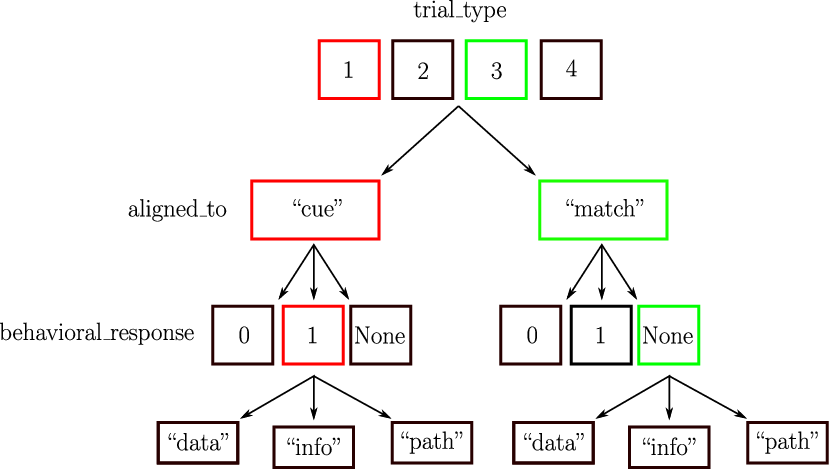

In [8]:
img = WImage(filename='img/data_hier.pdf')
img

If the h5 files were previously created the data in the session object can be also loaded from the h5 files using the method __read_from_h5__:

In [9]:
# Instantiate class
s_h5 = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
            slvr_msmod = False, align_to = 'cue', trial_type = 1, \
            behavioral_response = 1, evt_dt = [-0.65, 3.00])
# Read data from .mat files
s_h5.read_from_h5()

Let's compare the attibutes of s and s_h5 just as a sanity check:

In [11]:
print(s.data.shape)
print(s_h5.data.shape)

(540, 49, 3650)
(540, 49, 3650)


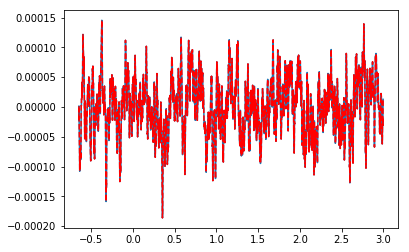

In [16]:
plt.plot(s.time, s.data[150,15,:])
plt.plot(s.time, s_h5.data[150,15,:], 'r--')

In [24]:
print(s.readinfo.keys())
print('\n')
print(s_h5.readinfo.keys())

dict_keys(['nC', 'nP', 'nT', 'pairs', 'indt', 'fsample', 'tarray', 'channels_labels', 'stim', 'indch', 'areas', 't_cue_on', 't_cue_off', 't_match_on'])


dict_keys(['areas', 'channels_labels', 'fsample', 'indch', 'indt', 'nC', 'nP', 'nT', 'pairs', 'stim', 't_cue_off', 't_cue_on', 't_match_on', 'tarray'])
